# 实践案例 ：标签传播算法的实现

/var/folders/3m/vg1kz23x7hj4xwwxmsrl6w7c0000gq/T/ipykernel_28385/3890331460.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[0] = radiu_inner * math.cos(pho) + np.random.rand(1) + center[0]
/var/folders/3m/vg1kz23x7hj4xwwxmsrl6w7c0000gq/T/ipykernel_28385/3890331460.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[1] = radiu_inner * math.sin(pho) + np.random.rand(1) + center[1]
/var/folders/3m/vg1kz23x7hj4xwwxmsrl6w7c0000gq/T/ipykernel_28385/3890331460.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array be

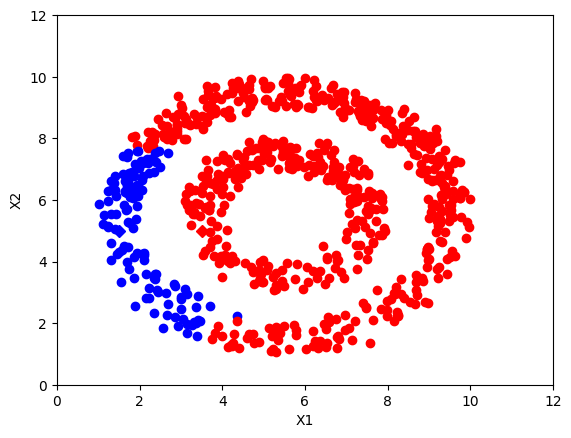

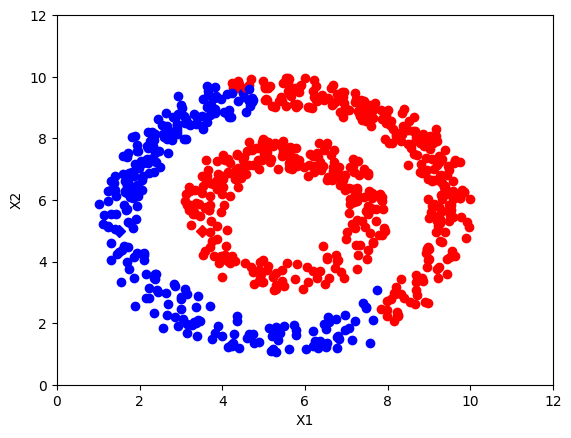

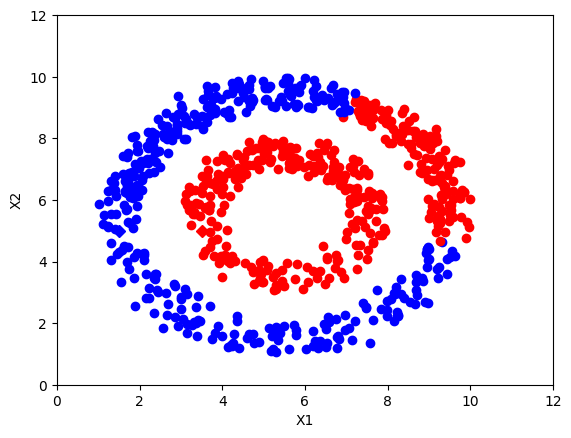

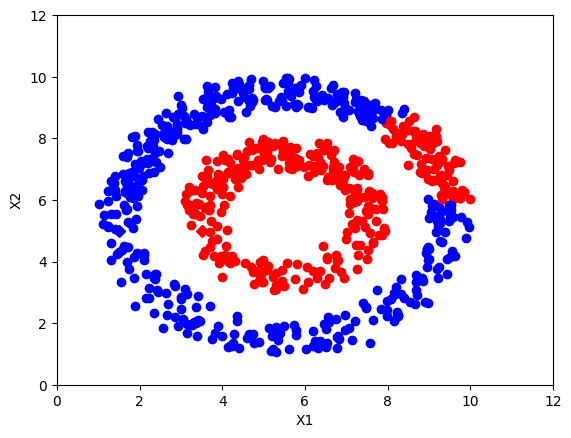

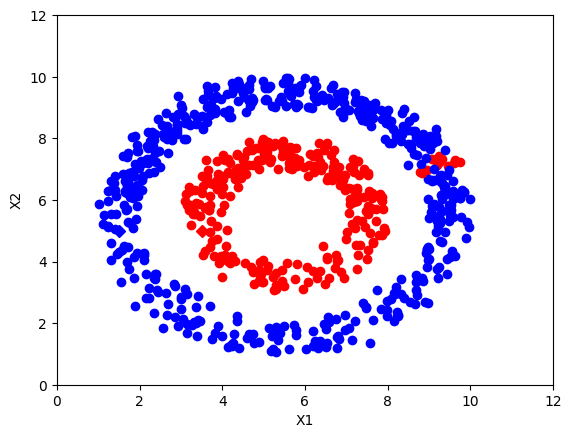

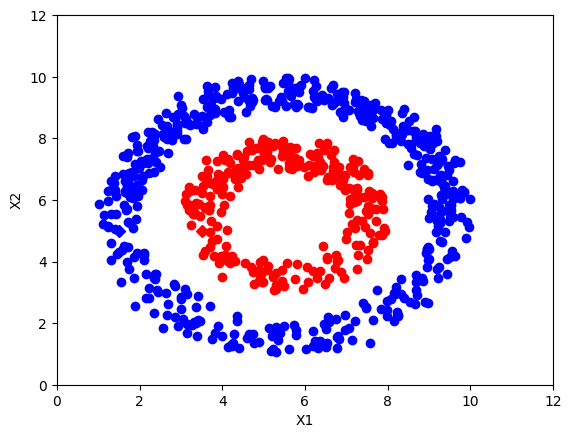

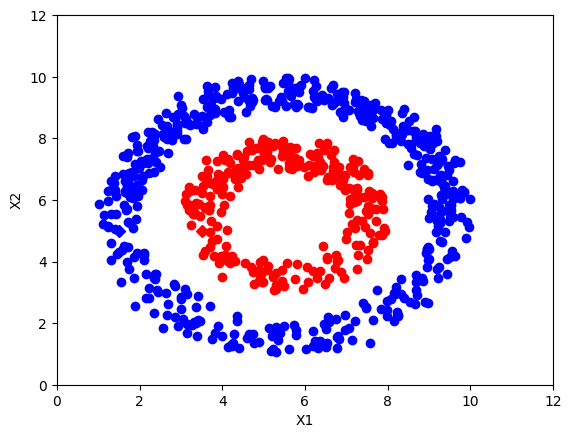

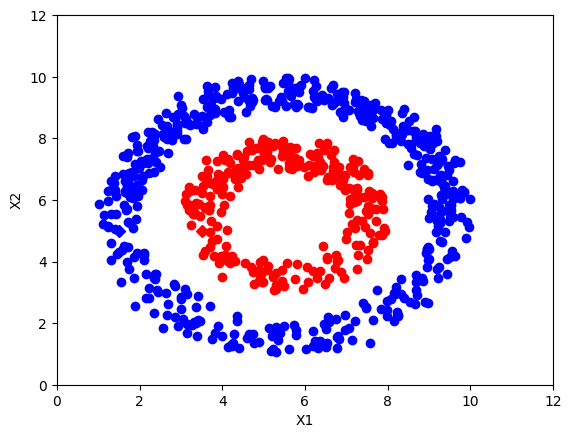

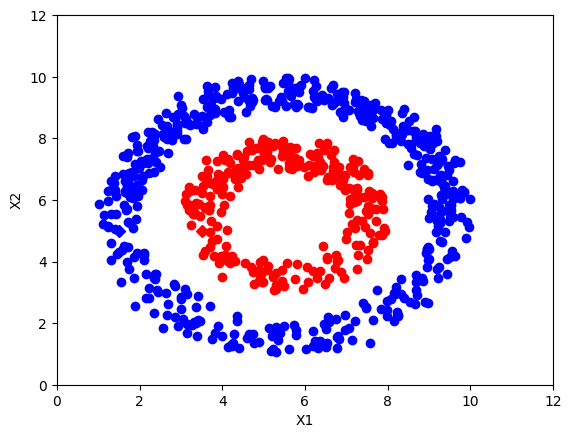

In [2]:
import time
import numpy as np
# return k neighbors index
def navie_knn(dataSet, query, k):
    numSamples = dataSet.shape[0]
    ## step 1: calculate Euclidean distance
    diff = np.tile(query, (numSamples, 1)) - dataSet
    squaredDiff = diff ** 2
    squaredDist = np.sum(squaredDiff, axis = 1) # sum is performed by row
    ## step 2: sort the distance
    sortedDistIndices = np.argsort(squaredDist)
    if k > len(sortedDistIndices):
        k = len(sortedDistIndices)
    return sortedDistIndices[0:k]
# build a big graph (normalized weight matrix)
def buildGraph(MatX, kernel_type, rbf_sigma = None, knn_num_neighbors = None):
    num_samples = MatX.shape[0]
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
    if kernel_type == 'rbf':
        if rbf_sigma == None:
            raise ValueError('You should input a sigma of rbf kernel!')
        for i in range(num_samples):
            row_sum = 0.0
            for j in range(num_samples):
                diff = MatX[i, :] - MatX[j, :]
                affinity_matrix[i][j] = np.exp(sum(diff**2) / (-2.0 * rbf_sigma**2))
                row_sum += affinity_matrix[i][j]
            affinity_matrix[i][:] /= row_sum
    elif kernel_type == 'knn':
        if knn_num_neighbors == None:
            raise ValueError('You should input a k of knn kernel!')
        for i in range(num_samples):
            k_neighbors = navie_knn(MatX, MatX[i, :], knn_num_neighbors)
            affinity_matrix[i][k_neighbors] = 1.0 / knn_num_neighbors
    else:
        raise NameError('Not support kernel type! You can use knn or rbf!')
    return affinity_matrix
# label propagation
def labelPropagation(Mat_Label, Mat_Unlabel, labels, kernel_type = 'rbf', rbf_sigma = 1.5, \
                     knn_num_neighbors = 10, max_iter = 500, tol = 1e-3):
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)
    MatX = np.vstack((Mat_Label, Mat_Unlabel))
    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0
    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0 : num_label_samples] = clamp_data_label
    label_function[num_label_samples : num_samples] = -1
    # graph construction
    affinity_matrix = buildGraph(MatX, kernel_type, rbf_sigma, knn_num_neighbors)
    # start to propagation
    iter = 0; pre_label_function = np.zeros((num_samples, num_classes), np.float32)
    changed = np.abs(pre_label_function - label_function).sum()
    while iter < max_iter and changed > tol:
        #if iter % 1 == 0:
        #print ("---> Iteration %d/%d, changed: %f" % (iter, max_iter,changed))
        pre_label_function = label_function
        iter += 1
        # propagation
        label_function = np.dot(affinity_matrix, label_function)
        # clamp
        label_function[0 : num_label_samples] = clamp_data_label
        # check converge
        changed = np.abs(pre_label_function - label_function).sum()
    # get terminate label of unlabeled data
    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in range(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i+num_label_samples])
    return unlabel_data_labels
import math
# from LabelPropagation import labelPropagation
# show
def show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels):
    import matplotlib.pyplot as plt
    for i in range(Mat_Label.shape[0]):
        if int(labels[i]) == 0:
            plt.plot(Mat_Label[i, 0], Mat_Label[i, 1], 'Dr')
        elif int(labels[i]) == 1:
            plt.plot(Mat_Label[i, 0], Mat_Label[i, 1], 'Db')
        else:
            plt.plot(Mat_Label[i, 0], Mat_Label[i, 1], 'Dy')
    for i in range(Mat_Unlabel.shape[0]):
        if int(unlabel_data_labels[i]) == 0:
            plt.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], 'or')
        elif int(unlabel_data_labels[i]) == 1:
            plt.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], 'ob')
        else:
            plt.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], 'oy')
    plt.xlabel('X1'); plt.ylabel('X2')
    plt.xlim(0.0, 12.)
    plt.ylim(0.0, 12.)
    plt.show()
def loadCircleData(num_data):
    center = np.array([5.0, 5.0])
    radiu_inner = 2
    radiu_outer = 4
    num_inner = int(num_data / 3)
    num_outer = num_data - num_inner
    data = []
    theta = 0.0
    for i in range(num_inner):
        pho = (theta % 360) * math.pi / 180
        tmp = np.zeros(2, np.float32)
        tmp[0] = radiu_inner * math.cos(pho) + np.random.rand(1) + center[0]
        tmp[1] = radiu_inner * math.sin(pho) + np.random.rand(1) + center[1]
        data.append(tmp)
        theta += 2
    theta = 0.0
    for i in range(num_outer):
        pho = (theta % 360) * math.pi / 180
        tmp = np.zeros(2, np.float32)
        tmp[0] = radiu_outer * math.cos(pho) + np.random.rand(1) + center[0]
        tmp[1] = radiu_outer * math.sin(pho) + np.random.rand(1) + center[1]
        data.append(tmp)
        theta += 1
    Mat_Label = np.zeros((2, 2), np.float32)
    Mat_Label[0] = center + np.array([-radiu_inner + 0.5, 0])
    Mat_Label[1] = center + np.array([-radiu_outer + 0.5, 0])
    labels = [0, 1]
    Mat_Unlabel = np.vstack(data)
    return Mat_Label, labels, Mat_Unlabel
def loadBandData(num_unlabel_samples):
    Mat_Label = np.array([[5.0, 2.], [5.0, 8.0]])
    labels = [0, 1]
    num_dim = Mat_Label.shape[1]
    Mat_Unlabel = np.zeros((num_unlabel_samples, num_dim), np.float32)
    Mat_Unlabel[:num_unlabel_samples/2, :] = (np.random.rand(num_unlabel_samples
                                                             /2, num_dim) - 0.5) * np.array([3, 1]) + Mat_Label[0]
    Mat_Unlabel[num_unlabel_samples/2 : num_unlabel_samples, :] = (np.random.
                                                                   rand(num_unlabel_samples/2, num_dim) - 0.5) * np.array([3, 1]) + Mat_Label[1]
    return Mat_Label, labels, Mat_Unlabel
#main function
if __name__ == "__main__":
    num_unlabel_samples = 800
    Mat_Label, labels, Mat_Unlabel = loadCircleData(num_unlabel_samples)
    iters = [10,50,100,150,200,250,300,350,400]
    for epoch in iters:
        unlabel_data_labels = labelPropagation(Mat_Label, Mat_Unlabel, labels,
                                               kernel_type = 'knn', knn_num_neighbors = 10, max_iter = epoch)
        show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels)


# 实践案例二：协同训练算法的实现

In [3]:
import numpy as np
import random
import copy
class CoTrainingClassifier(object):
    def __init__(self, clf, clf2=None, p=-1, n=-1, k=30, u = 75):
        self.clf1_ = clf
        if clf2 == None:
            self.clf2_ = copy.copy(clf)
        else:
            self.clf2_ = clf2
        #if they only specify one of n or p, through an exception
        if (p == -1 and n != -1) or (p != -1 and n == -1):
            raise ValueError("set only one of n/p ")
        self.p_ = p
        self.n_ = n
        self.k_ = k
        self.u_ = u
        random.seed()
    def fit(self, X1, X2, y):
        y = np.asarray(y)
        if self.p_ == -1 and self.n_ == -1:
            num_pos = sum(1 for y_i in y if y_i == 1)
            num_neg = sum(1 for y_i in y if y_i == 0)
            n_p_ratio = num_neg / float(num_pos)
            if n_p_ratio > 1:
                self.p_ = 1
                self.n_ = round(self.p_*n_p_ratio)
            else:
                self.n_ = 1
                self.p_ = round(self.n_/n_p_ratio)
        assert(self.p_ > 0 and self.n_ > 0 and self.k_ > 0 and self.u_ > 0)
        U = [i for i, y_i in enumerate(y) if y_i == -1]
        random.shuffle(U)
        U_ = U[-min(len(U), self.u_):]
        L = [i for i, y_i in enumerate(y) if y_i != -1]
        U = U[:-len(U_)]
        it = 0
        while it != self.k_ and U:
            it += 1
            self.clf1_.fit(X1[L], y[L])
            self.clf2_.fit(X2[L], y[L])
            y1_prob = self.clf1_.predict_proba(X1[U_])
            y2_prob = self.clf2_.predict_proba(X2[U_])
            n, p = [], []
            for i in (y1_prob[:,0].argsort())[-self.n_:]:
                if y1_prob[i,0] > 0.5:
                    n.append(i)
            for i in (y1_prob[:,1].argsort())[-self.p_:]:
                if y1_prob[i,1] > 0.5:
                    p.append(i)
            for i in (y2_prob[:,0].argsort())[-self.n_:]:
                if y2_prob[i,0] > 0.5:
                    n.append(i)
            for i in (y2_prob[:,1].argsort())[-self.p_:]:
                if y2_prob[i,1] > 0.5:
                    p.append(i)
            y[[U_[x] for x in p]] = 1
            y[[U_[x] for x in n]] = 0
            L.extend([U_[x] for x in p])
        L.extend([U_[x] for x in n])
        U_ = [elem for elem in U_ if not (elem in p or elem in n)]
        add_counter = 0
        num_to_add = len(p) + len(n)
        while add_counter != num_to_add and U:
            add_counter += 1
            U_.append(U.pop())
        self.clf1_.fit(X1[L], y[L])
        self.clf2_.fit(X2[L], y[L])
    def supports_proba(self, clf, x):
        try:
            clf.predict_proba([x])
            return True
        except:
            return False
    def predict(self, X1, X2):
        y1 = self.clf1_.predict(X1)
        y2 = self.clf2_.predict(X2)
        proba_supported = self.supports_proba(self.clf1_, X1[0]) and self.supports_proba(self.clf2_, X2[0])
        y_pred = np.asarray([-1] * X1.shape[0])
        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            if y1_i == y2_i:
                y_pred[i] = y1_i
            elif proba_supported:
                y1_probs = self.clf1_.predict_proba([X1[i]])[0]
                y2_probs = self.clf2_.predict_proba([X2[i]])[0]
                sum_y_probs = [prob1 + prob2 for (prob1, prob2) in zip(y1_probs,
                                                                       y2_probs)]
                max_sum_prob = max(sum_y_probs)
                y_pred[i] = sum_y_probs.index(max_sum_prob)
            else:
                y_pred[i] = random.randint(0, 1)
        assert not (-1 in y_pred)
        return y_pred
    def predict_proba(self, X1, X2):
        y_proba = np.full((X1.shape[0], 2), -1)
        y1_proba = self.clf1_.predict_proba(X1)
        y2_proba = self.clf2_.predict_proba(X2)
        for i, (y1_i_dist, y2_i_dist) in enumerate(zip(y1_proba, y2_proba)):
            y_proba[i][0] = (y1_i_dist[0] + y2_i_dist[0]) / 2
            y_proba[i][1] = (y1_i_dist[1] + y2_i_dist[1]) / 2
        _epsilon = 0.0001
        assert all(abs(sum(y_dist) - 1) <= _epsilon for y_dist in y_proba)
        return y_proba

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
N_SAMPLES = 25000
N_FEATURES = 1000
X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES)
y[:N_SAMPLES//2] = -1
X_test = X[-N_SAMPLES//4:]
y_test = y[-N_SAMPLES//4:]
X_labeled = X[N_SAMPLES//2:-N_SAMPLES//4]
y_labeled = y[N_SAMPLES//2:-N_SAMPLES//4]
y = y[:-N_SAMPLES//4]
X = X[:-N_SAMPLES//4]
X1 = X[:,:N_FEATURES // 2]
X2 = X[:, N_FEATURES // 2:]
print ('RandomForestClassifier')
base_lr = RandomForestClassifier()
base_lr.fit(X_labeled, y_labeled)
y_pred = base_lr.predict(X_test)
print (classification_report(y_test, y_pred))
print ('RandomForestClassifier CoTraining')
lg_co_clf = CoTrainingClassifier(RandomForestClassifier())
lg_co_clf.fit(X1, X2, y)
y_pred = lg_co_clf.predict(X_test[:, :N_FEATURES // 2], X_test[:, N_FEATURES //
2:])
print (classification_report(y_test, y_pred))

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3103
           1       0.96      0.96      0.96      3147

    accuracy                           0.96      6250
   macro avg       0.96      0.96      0.96      6250
weighted avg       0.96      0.96      0.96      6250

RandomForestClassifier CoTraining
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3103
           1       0.96      0.96      0.96      3147

    accuracy                           0.96      6250
   macro avg       0.96      0.96      0.96      6250
weighted avg       0.96      0.96      0.96      6250

